In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""


df = pd.read_sql(query, conn)
df

,age,gender,patient
0,40,F,0220e8b3-e108-768c-dfcf-22ad951ae7ac
1,40,M,034f2cbf-41f7-53b5-9cbb-9c69f3c3ae1e
2,40,F,03b204cd-c4e6-30a0-57f2-7f7e182da896
3,40,M,04b64150-7905-97c4-6ce7-12134e09b24c
4,40,M,04d185d2-0af9-a96a-a035-0b22861e0e51
...,...,...,...
9231,80,F,e89dd75a-f0fc-3bdf-a062-ac047cf72e33
9232,80,F,ea0c6652-cb7f-e564-0e17-ce251bd074c0
9233,80,F,f0b72501-8806-4cbf-31e2-541c5913bc87
9234,80,F,f99d16b5-ca1b-1fda-820c-096878b91d30


In [2]:
womenMeanDf = df.where(df.gender == "F").dropna().mean()
menMeanDf = df.where(df.gender == "M").dropna().mean()

C:\Users\krist\AppData\Local\Temp\ipykernel_15244\3459853752.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  womenMeanDf = df.where(df.gender == "F").dropna().mean()
C:\Users\krist\AppData\Local\Temp\ipykernel_15244\3459853752.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  menMeanDf = df.where(df.gender == "M").dropna().mean()


MALES Below


In [3]:
import numpy.random as np
howManyMenQuery = """
SELECT COUNT(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""

maxMaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""


howManyMenDF = pd.read_sql(howManyMenQuery, conn)
maxMaleDF = pd.read_sql(maxMaleQuery, conn)
nOfMen = int(howManyMenDF.to_string(index=False, header=False))
maxMaleage = int(maxMaleDF.to_string(index=False, header=False))


print(nOfMen)
menavg = menMeanDf["age"].astype(float)

5792


FEMALES below

In [4]:
maxFemaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""

howManyWomenQuery = """
SELECT count(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""


howManyWomenDF = pd.read_sql(howManyWomenQuery, conn)
nOfWomen = int(howManyWomenDF.to_string(index=False, header=False))
maxFemaleDF = pd.read_sql(maxFemaleQuery, conn)
maxFemaleAge = int(maxMaleDF.to_string(index=False, header=False))

print(nOfWomen)
womenavg = womenMeanDf["age"].astype(float)


3444


Make a distribution for both men and women

3.9213396987955704
58.84188531901104


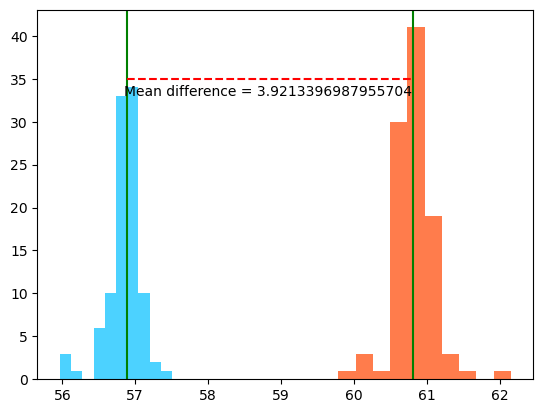

In [5]:
import numpy.random as np
import numpy as npp
menArr = []
womenArr = []

for i in range(100):

    deltaWomen = maxFemaleAge / nOfWomen
    scaleWomen = deltaWomen / 0.1
    lapWomen = np.laplace(0, scaleWomen)

    womenArr.append(womenavg+lapWomen)

    delta = maxMaleage / nOfMen
    scale = delta / 0.1
    lap = np.laplace(0, scale)

    menArr.append(menavg+lap)



plt.hist(menArr, color="deepskyblue", alpha=0.7)
plt.axvline(x=womenavg, color="g")
plt.axvline(x=menavg, color ="g")

x= [menavg, womenavg]
y=[35, 35]

plt.plot(x, y, linestyle="--", color="r")

difference = womenavg-menavg
print(difference)
swag = (womenavg+menavg) / 2
print(swag)
plt.text(swag-2, 33, "Mean difference = " + str(difference))



plt.hist(womenArr, color="orangered", alpha=0.7)
plt.show()


With DP

In [6]:
# calculate the Cohen's d between two samples
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

dBDP = cohend(womenArr, menArr)
print("After DP, for men and women: ", dBDP)


After DP, for men and women:  15.457537228162717


Try with the epsilon vs effect size in this experiment



In [7]:

# Python program to illustrate
# enumerate function
import numpy as np

for  i in np.arange(0.5, 1.5, 0.2):
    print(i, end =" ")#%%
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""


df = pd.read_sql(query, conn)
df

0.5 0.7 0.8999999999999999 1.0999999999999999 1.2999999999999998 

,age,gender,patient
0,40,F,0220e8b3-e108-768c-dfcf-22ad951ae7ac
1,40,M,034f2cbf-41f7-53b5-9cbb-9c69f3c3ae1e
2,40,F,03b204cd-c4e6-30a0-57f2-7f7e182da896
3,40,M,04b64150-7905-97c4-6ce7-12134e09b24c
4,40,M,04d185d2-0af9-a96a-a035-0b22861e0e51
...,...,...,...
9231,80,F,e89dd75a-f0fc-3bdf-a062-ac047cf72e33
9232,80,F,ea0c6652-cb7f-e564-0e17-ce251bd074c0
9233,80,F,f0b72501-8806-4cbf-31e2-541c5913bc87
9234,80,F,f99d16b5-ca1b-1fda-820c-096878b91d30


In [8]:
womenMeanDf = df.where(df.gender == "F").dropna().mean()
menMeanDf = df.where(df.gender == "M").dropna().mean()

C:\Users\krist\AppData\Local\Temp\ipykernel_15244\3459853752.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  womenMeanDf = df.where(df.gender == "F").dropna().mean()
C:\Users\krist\AppData\Local\Temp\ipykernel_15244\3459853752.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  menMeanDf = df.where(df.gender == "M").dropna().mean()


MALES Below


In [9]:
import numpy.random as np
howManyMenQuery = """
SELECT COUNT(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""

maxMaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""


howManyMenDF = pd.read_sql(howManyMenQuery, conn)
maxMaleDF = pd.read_sql(maxMaleQuery, conn)
nOfMen = int(howManyMenDF.to_string(index=False, header=False))
maxMaleage = int(maxMaleDF.to_string(index=False, header=False))


print(nOfMen)
menavg = menMeanDf["age"].astype(float)

5792


FEMALES below

In [10]:
maxFemaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""

howManyWomenQuery = """
SELECT count(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""


howManyWomenDF = pd.read_sql(howManyWomenQuery, conn)
nOfWomen = int(howManyWomenDF.to_string(index=False, header=False))
maxFemaleDF = pd.read_sql(maxFemaleQuery, conn)
maxFemaleAge = int(maxMaleDF.to_string(index=False, header=False))

print(nOfWomen)
womenavg = womenMeanDf["age"].astype(float)


3444


Make a distribution for both men and women

3.9213396987955704
58.84188531901104


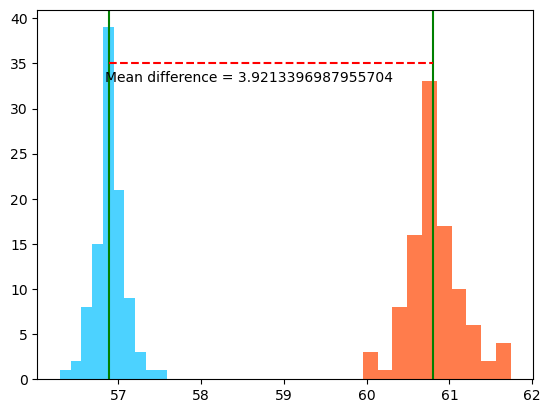

In [11]:
import numpy.random as np
import numpy as npp
menArr = []
womenArr = []

for i in range(100):

    deltaWomen = maxFemaleAge / nOfWomen
    scaleWomen = deltaWomen / 0.1
    lapWomen = np.laplace(0, scaleWomen)

    womenArr.append(womenavg+lapWomen)

    delta = maxMaleage / nOfMen
    scale = delta / 0.1
    lap = np.laplace(0, scale)

    menArr.append(menavg+lap)



plt.hist(menArr, color="deepskyblue", alpha=0.7)
plt.axvline(x=womenavg, color="g")
plt.axvline(x=menavg, color ="g")

x= [menavg, womenavg]
y=[35, 35]

plt.plot(x, y, linestyle="--", color="r")

difference = womenavg-menavg
print(difference)
swag = (womenavg+menavg) / 2
print(swag)
plt.text(swag-2, 33, "Mean difference = " + str(difference))



plt.hist(womenArr, color="orangered", alpha=0.7)
plt.show()


With DP

In [12]:
# calculate the Cohen's d between two samples
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

dBDP = cohend(womenArr, menArr)
print("After DP, for men and women: ", dBDP)

After DP, for men and women:  14.548297351113616


Try with the epsilon vs effect size in this experiment



In [18]:

# Python program to illustrate
# enumerate function
import numpy.random as np
import numpy as npp
menArr = [[] for _ in range(10)]
womenArr = [[] for _ in range(10)]
epsilons = []
cohends = [[] for _ in range(10)]
count = 0

for  i in npp.arange(0.01, 1, 0.1):

    if i>0.02 : i = round(i,1)
    epsilons.append(i)
    print(i)

    for y in npp.arange(0,100,1):
        print(y, count)
        deltaWomen = maxFemaleAge / nOfWomen
        scaleWomen = deltaWomen / i
        lapWomen = np.laplace(0, scaleWomen)

        womenArr[count].append(womenavg+lapWomen)


        delta = maxMaleage / nOfMen
        scale = delta / i
        lap = np.laplace(0, scale)
        menArr[count].append(menavg+lap)
        cohends[count].append(cohend(womenArr[count], menArr[count]))


count = count + 1



for q in npp.arange(0,10,1):
    for v in range(50):
        cohends[q].append(cohend(womenArr[q], menArr[q]))
        print("hehe", q)
        print("men", menArr[q])
        print("women", womenArr[q])
cohends


0.01
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
0.1
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
0.2
0 2
1 2

[[1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.6705724070487251,
  1.670572

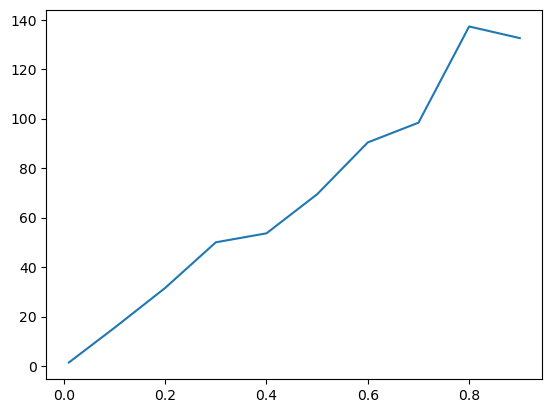

In [14]:
plt.cla()
plt.plot(epsilons, cohends)

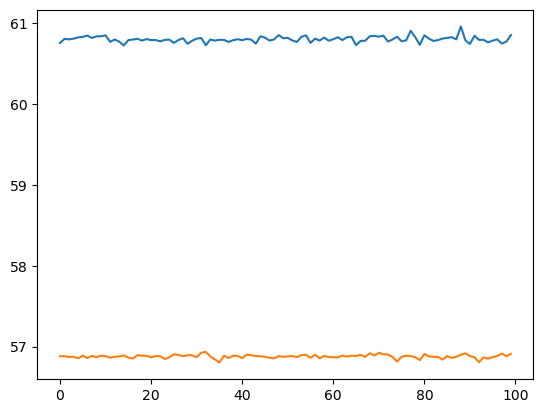

In [15]:
plt.cla()
plt.plot(womenArr[9])
plt.plot(menArr[9])

In [16]:
print(womenArr[9])

[60.75743277127147, 60.80765708221575, 60.80095161006744, 60.81056444545909, 60.82617903617986, 60.832330823934335, 60.848470452840715, 60.81851643526068, 60.838257280374044, 60.83904973392366, 60.85108101253951, 60.77085596438169, 60.79933926571046, 60.773348494286815, 60.72607312196153, 60.79198428111974, 60.798813336828324, 60.80893081290062, 60.785805835537545, 60.804961521276574, 60.792394363737145, 60.792987414371986, 60.77722198185785, 60.79464306117005, 60.79827836330321, 60.757715006948004, 60.79280315790155, 60.81533809497997, 60.74661326540416, 60.783452359603714, 60.81069001799631, 60.81766264449247, 60.73005912871677, 60.79879985384944, 60.78669801667908, 60.7957843996436, 60.79454147094235, 60.76984828625392, 60.79080402986267, 60.803159186794545, 60.791860296525364, 60.80663165847238, 60.79700832783027, 60.747855071132655, 60.84024977677369, 60.82328532490565, 60.78631676215644, 60.80047140248327, 60.85405632416128, 60.81540542125806, 60.820100797920425, 60.7883816387091